## What would have happened to Peru if they beat Australia on June 13, 2022?

Peru lost the opportunity to play the world cup 2022 among many things, due to losing the game against australia on june 13, 2022. with the recent info we have from some dataset i'll try to guess what would be our performance on that world cup.

In [44]:
# import Libraries
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import lime
from lime import lime_tabular
import shap

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plotter(x, y, title):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

#### The following is all the national team game results up to 2024. (from Kaggle https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), in the "Training_games" csv there are all the games of 2022 until the start of the world cup on november 20.

In [3]:

Game_all = pd.read_csv('Training_games.csv')
Game_all.head()

,Unnamed: 0,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2022-01-02,Gabon,Burkina Faso,0.0,3.0,Friendly,Dubai,United Arab Emirates,True
1,2022-01-02,Sudan,Zimbabwe,0.0,0.0,Friendly,Yaoundé,Cameroon,True
2,2022-01-03,Rwanda,Guinea,3.0,0.0,Friendly,Kigali,Rwanda,False
3,2022-01-04,Mauritania,Gabon,1.0,1.0,Friendly,Dubai,United Arab Emirates,True
4,2022-01-05,Algeria,Ghana,3.0,0.0,Friendly,Al Rayyan,Qatar,True


##### I've replaced Australia with Peru, on the list of teams that played the WC 2022

In [4]:
#Team = pd.DataFrame({'team':['Senegal','Qatar','Netherlands','Ecuador','Iran','England','United States','Wales','Argentina','Saudi Arabia','Mexico','Poland','Denmark','Tunisia','France','Australia','Germany','Japan','Spain','Costa Rica','Morocco','Croatia','Belgium','Canada','Switzerland','Cameroon','Brazil','Serbia','Uruguay','Korea Republic','Portugal','Ghana']})
Teams = ['Senegal','Qatar','Netherlands','Ecuador','Iran','England','United States','Wales','Argentina','Saudi Arabia','Mexico','Poland','Denmark','Tunisia','France','Peru','Germany','Japan','Spain','Costa Rica','Morocco','Croatia','Belgium','Canada','Switzerland','Cameroon','Brazil','Serbia','Uruguay','Korea Republic','Portugal','Ghana']

In [5]:
# just to normalize the name of the team on the table
Game_all = Game_all.replace('South Korea','Korea Republic')
Game_all.head()

,Unnamed: 0,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2022-01-02,Gabon,Burkina Faso,0.0,3.0,Friendly,Dubai,United Arab Emirates,True
1,2022-01-02,Sudan,Zimbabwe,0.0,0.0,Friendly,Yaoundé,Cameroon,True
2,2022-01-03,Rwanda,Guinea,3.0,0.0,Friendly,Kigali,Rwanda,False
3,2022-01-04,Mauritania,Gabon,1.0,1.0,Friendly,Dubai,United Arab Emirates,True
4,2022-01-05,Algeria,Ghana,3.0,0.0,Friendly,Al Rayyan,Qatar,True


##### In order to have only the games of the list that were played by at least one of the classified countries, i'm filtering this way:

In [6]:
Game_used = Game_all.drop(Game_all[(~Game_all['home_team'].isin(Teams)) | (~Game_all['away_team'].isin(Teams)) ].index)
Game_used.count()
Game_used

,Unnamed: 0,home_team,away_team,home_score,away_score,tournament,city,country,neutral
10,2022-01-10,Morocco,Ghana,1.0,0.0,African Cup of Nations,Yaoundé,Cameroon,True
72,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False
87,2022-01-30,Canada,United States,2.0,0.0,FIFA World Cup qualification,Hamilton,Canada,False
88,2022-01-30,Mexico,Costa Rica,0.0,0.0,FIFA World Cup qualification,Mexico City,Mexico,False
100,2022-02-01,Japan,Saudi Arabia,2.0,0.0,FIFA World Cup qualification,Saitama,Japan,False
...,...,...,...,...,...,...,...,...,...
709,2022-09-27,Ecuador,Japan,0.0,0.0,Kirin Challenge Cup,Düsseldorf,Germany,True
715,2022-09-27,Iran,Senegal,1.0,1.0,Friendly,Maria Enzersdorf,Austria,True
717,2022-09-27,Korea Republic,Cameroon,1.0,0.0,Friendly,Seoul,Korea Republic,False
727,2022-09-27,Saudi Arabia,United States,0.0,0.0,Friendly,Murcia,Spain,True


##### The following dataset is from kaggle (https://www.kaggle.com/datasets/cashncarry/fifa-23-complete-player-dataset) there is a complete and updated profile of the pro players according to fifa 2022.

In [7]:
Player_all = pd.read_csv('Player.csv')
Player_all.head()

,Name,FullName,Age,Height,Weight,Nationality,Overall,Positions,PreferredFoot,IntReputation,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,L. Messi,Lionel Messi,35,169,67,Argentina,91,RW,Left,5,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,34,185,81,France,91,"CF,ST",Right,4,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,33,185,81,Poland,91,ST,Right,5,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,31,181,70,Belgium,91,"CM,CAM",Right,4,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,23,182,73,France,91,"ST,LW",Right,4,...,92,84,92,70,66,70,66,57,66,21


In [8]:
Player_all.loc[Player_all.FullName == 'André Carrillo']

,Name,FullName,Age,Height,Weight,Nationality,Overall,Positions,PreferredFoot,IntReputation,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
795,A. Carrillo,André Carrillo,31,182,78,Peru,78,"RW,CM",Right,2,...,78,73,78,63,60,63,60,55,60,20


#### I've got the starting team for each country of those 63 games played by at least one the classified teams on 2022, in the following table there is a list of the games and the starting team of each of those games.

In [9]:
Game_63 = pd.read_csv('Training_game_63.csv')

#show the first player in the first of the 62 training games
Player_all.loc[(Game_63.loc[0]['Player1'])]

Name              Y. Bounou
FullName     Yassine Bounou
Age                      31
Height                  192
Weight                   78
                  ...      
RWBRating                30
LBRating                 29
CBRating                 30
RBRating                 29
GKRating                 84
Name: 100, Length: 71, dtype: object

#### Since i want to have the age of the players as one of the fetures my model uses for prediction, im taking the average age of each team on my 63 previous games dataset.

In [10]:
team_age=[]
for j in range(63):
    
    # Get the team1 and team2 player index from the Team DataFrame
    team1_index = list(Game_63.loc[j][8:19])
    team2_index = list(Game_63.loc[j][19:30])
    
    # Average of the team age
    temp1 = Player_all.iloc[team1_index]['Age'].mean()
    temp2 = Player_all.iloc[team2_index]['Age'].mean()
    team_age.append([temp1,temp2])
    
# Create the DataFrame for the average age    
cols = ['Average_age1','Average_age2']
Train_df_age = pd.DataFrame(team_age, columns=cols)
Train_df_age.head()

,Average_age1,Average_age2
0,26.181818,27.000000
1,25.545455,27.454545
2,27.272727,23.545455
3,27.181818,28.090909
4,28.090909,27.454545


#### Also i want to have the overall rating of each player (according to fifa dataset) to be a feature in my model, so im taking the overall score of each starting player ob both teams of every encounter.

In [11]:
team_overall=[]
for j in range(63):
    
    # Get the full team1 and team2 player index from the Team DataFrame
    team_index = list(Game_63.loc[j][8:30])
    
    # The team1 and team2 player overall from the Team DataFrame
    temp3 = Player_all.iloc[team_index]['Overall']
    team_overall.append(list(temp3))
    
# Create the DataFrame for the player overall    
cols = []
for i in range(22):
    cols.append('Player'+str(i+1)+'_overall') 
Train_df_overall = pd.DataFrame(team_overall, columns=cols)
Train_df_overall.head()

,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,Player9_overall,Player10_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,84,84,77,80,74,71,70,73,74,77,...,72,76,77,70,84,75,71,75,75,75
1,72,69,78,69,79,66,72,70,77,75,...,78,84,86,80,83,80,89,86,81,82
2,77,70,69,71,70,72,71,72,74,79,...,77,73,74,74,74,76,80,74,71,82
3,80,76,77,76,75,80,65,76,81,76,...,74,69,67,62,71,71,68,67,71,70
4,72,79,75,74,74,78,78,71,76,75,...,72,68,67,73,66,69,66,70,77,65


#### Concat them tables on axis 1 (columns)

In [12]:
Train_df=pd.concat([Train_df_age, Train_df_overall],axis=1)

In [13]:
Train_df.head()

,Average_age1,Average_age2,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,26.181818,27.000000,84,84,77,80,74,71,70,73,...,72,76,77,70,84,75,71,75,75,75
1,25.545455,27.454545,72,69,78,69,79,66,72,70,...,78,84,86,80,83,80,89,86,81,82
2,27.272727,23.545455,77,70,69,71,70,72,71,72,...,77,73,74,74,74,76,80,74,71,82
3,27.181818,28.090909,80,76,77,76,75,80,65,76,...,74,69,67,62,71,71,68,67,71,70
4,28.090909,27.454545,72,79,75,74,74,78,78,71,...,72,68,67,73,66,69,66,70,77,65


#### Im creating a numpy matrix of [1,63] of the result of the games, to play the role of the known variable for my model

In [14]:
Result_training = []
Result_totalgoal = []
Result_netgoal = []
for j in range(63):
    Result_training.append(Game_63.loc[j]['Result'])
    Result_totalgoal.append(Game_63.loc[j]['Netgoal'])
    Result_netgoal.append(Game_63.loc[j]['Goal_total'])
np.array(Result_training)
np.array(Result_totalgoal)
np.array(Result_netgoal)

array([1, 2, 2, 0, 2, 2, 0, 1, 2, 1, 3, 6, 2, 3, 2, 2, 3, 3, 2, 6, 3, 3,
       5, 4, 0, 0, 2, 1, 2, 3, 7, 1, 1, 5, 2, 4, 1, 1, 5, 1, 3, 3, 3, 2,
       2, 3, 2, 1, 4, 0, 1, 3, 2, 1, 1, 6, 6, 2, 0, 2, 1, 0, 1])

#### In the matches files there are all the games played in the groups stage replacing Australia with peru

In [15]:

match = pd.read_csv('matches_group.csv')
match.head()

,match,date,country1,country2,phase,Unnamed: 5,Unnamed: 6
0,1,21/11/2022,Qatar,Ecuador,group matches,NaN,NaN
1,2,21/11/2022,Senegal,Netherlands,group matches,NaN,NaN
2,3,21/11/2022,England,Iran,group matches,NaN,NaN
3,4,21/11/2022,United States,Wales,group matches,NaN,NaN
4,5,22/11/2022,France,Peru,group matches,NaN,NaN


#### Teams is the dataset of the starting 11 playerrs of each country

In [16]:

Team = pd.read_csv('Teams.csv')
Team.head()

,Unnamed: 0,Team,Group,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Player9,Player10,Player11
0,1,Senegal,A,62,2931,40,1070,2638,2096,248,906,1974,545,15
1,2,Qatar,A,6227,5537,6460,9282,10707,7036,4160,3505,10006,3300,1086
2,3,Netherlands,A,428,84,9,405,237,237,272,42,397,75,481
3,4,Ecuador,A,2979,5570,689,5447,515,9016,3009,4427,990,1730,1758
4,5,Iran,B,3568,3353,14410,6635,3068,10316,2689,3143,4477,296,489


#### Next im doing exactly the same excercise (of extracting the features dataset) but with the 48 games of the group stage.

In [17]:
team_age=[]
for j in range(48):
    
    # Get the team1 and team2 player index from the Team DataFrame
    team1_index = list(Team.loc[Team['Team'] == match['country1'][j]].iloc[0,3:])
    team2_index = list(Team.loc[Team['Team'] == match['country2'][j]].iloc[0,3:])
    
    # Average of the team age
    temp1 = Player_all.iloc[team1_index]['Age'].mean()
    temp2 = Player_all.iloc[team2_index]['Age'].mean()
    team_age.append([temp1,temp2])

# Create the DataFrame for the average age
cols = ['Average_age1','Average_age2']
Predic_df_age = pd.DataFrame(team_age, columns=cols)
Predic_df_age.head()

,Average_age1,Average_age2
0,27.000000,25.545455
1,28.090909,26.272727
2,25.909091,28.181818
3,24.363636,24.909091
4,27.181818,30.181818


In [18]:
team_overall=[]
for j in range(48):
    
    # Get the full team1 and team2 player index from the Team DataFrame
    team_index = list(Team.loc[Team['Team'] == match['country1'][j]].iloc[0,3:]) + list(Team.loc[Team['Team'] == match['country2'][j]].iloc[0,3:])
    
    # The team1 and team2 player overall from the Team DataFrame
    temp3 = Player_all.iloc[team_index]['Overall']
    team_overall.append(list(temp3))

# Create the DataFrame for the player overall
cols = []
for i in range(22):
    cols.append('Player'+str(i+1)+'_overall') 
Predic_df_overall = pd.DataFrame(team_overall, columns=cols)
Predic_df_overall.head()

,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,Player9_overall,Player10_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,68,69,68,66,65,68,71,72,65,72,...,69,78,69,79,66,72,70,77,75,75
1,86,73,87,77,73,74,82,77,74,79,...,85,90,80,82,82,82,87,80,85,80
2,81,83,80,85,84,84,84,80,85,86,...,72,61,68,72,65,73,72,70,81,80
3,77,70,76,73,77,72,76,80,77,69,...,70,72,68,75,67,66,71,75,77,81
4,87,84,83,84,86,85,82,85,83,91,...,76,74,73,72,79,72,75,78,73,73


In [19]:
Predicting_df=pd.concat([Predic_df_age, Predic_df_overall],axis=1)

In [20]:
Predicting_df.head()

,Average_age1,Average_age2,Player1_overall,Player2_overall,Player3_overall,Player4_overall,Player5_overall,Player6_overall,Player7_overall,Player8_overall,...,Player13_overall,Player14_overall,Player15_overall,Player16_overall,Player17_overall,Player18_overall,Player19_overall,Player20_overall,Player21_overall,Player22_overall
0,27.000000,25.545455,68,69,68,66,65,68,71,72,...,69,78,69,79,66,72,70,77,75,75
1,28.090909,26.272727,86,73,87,77,73,74,82,77,...,85,90,80,82,82,82,87,80,85,80
2,25.909091,28.181818,81,83,80,85,84,84,84,80,...,72,61,68,72,65,73,72,70,81,80
3,24.363636,24.909091,77,70,76,73,77,72,76,80,...,70,72,68,75,67,66,71,75,77,81
4,27.181818,30.181818,87,84,83,84,86,85,82,85,...,76,74,73,72,79,72,75,78,73,73


##### since i've concatenated the features dataset, im taking as my train data X_1 (everything up to game 63, cause those are all the games played before the WC), standard scaler adjust the values to have the samme distribution but with a mean of 0 and a std deviation of 1, it recommended for this types of work for all the features to be comparable.

In [21]:
All_df = pd.concat([Train_df,Predicting_df],axis=0)
All_df = preprocessing.StandardScaler().fit(All_df).transform(All_df.astype(float))
X_1 = All_df[:63]
X_2 = All_df[63:]

#### this function splits the dataset into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_1, np.array(Result_training), test_size=0.1, random_state=42)
#X_train.shape, X_test.shape
X_train

array([[-1.42010391e+00,  6.05160614e-01, -9.40764569e-01, ...,
        -8.80809878e-01,  2.60665409e+00,  1.70509965e-01],
       [-2.22734175e+00,  2.41340225e-03, -7.95326036e-01, ...,
        -5.22021267e-01,  6.34479696e-02,  5.08485075e-01],
       [ 7.08068571e-01, -1.98502335e-01, -1.23164164e+00, ...,
        -5.22021267e-01, -5.23445749e-01, -6.74427810e-01],
       ...,
       [ 1.20986506e-01, -6.00333809e-01,  1.67712904e+00, ...,
         1.09252748e+00,  1.62849789e+00,  1.69139796e+00],
       [-6.86251332e-01,  4.71216789e-01,  6.59059301e-01, ...,
         3.74950260e-01, -5.23445749e-01, -3.36452700e-01],
       [-1.42010391e+00, -1.47096867e+00,  2.22743700e-01, ...,
        -3.42626962e-01, -5.23445749e-01, -3.36452700e-01]])

#### Im using a multi layer perceptron as the model, i'm doing it so through tthe GridsearchCV funtion to try many combinations of parameters.

In [41]:
# Your code that generates warnings

parameters = {'hidden_layer_sizes':[10, 25, 50, 75, 100, 150],
              'alpha': [0.0001, 0.001, 0.01, 0.1, 0.005], 
              'max_iter': [800], 
              'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

model = MLPClassifier()
clf = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1)

clf.fit(X_train, y_train) # may need to reduce the train set size to shorten the training time
# To ignore all warnings

print("The best parameter values found are:\n")
print(clf.best_params_)

# store the best model found in "bestmodel"
bestmodel = clf.best_estimator_

/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/skle

KeyboardInterrupt: 

In [32]:
y_prob = bestmodel.predict_proba(X_test)
y_pred = bestmodel.predict(X_test)
#print(f"The accuracy score of the best model is {accuracy_score(y_test, y_pred)}\n")
print([np.round(y_prob,3), y_pred, y_test])
# D/L/W probality; Predicted result; Real Result

[array([[0.457, 0.217, 0.326],
       [0.309, 0.395, 0.297],
       [0.215, 0.15 , 0.635],
       [0.458, 0.333, 0.209],
       [0.3  , 0.125, 0.575],
       [0.221, 0.33 , 0.449],
       [0.2  , 0.161, 0.639]]), array(['D', 'L', 'W', 'D', 'W', 'W', 'W'], dtype='<U1'), array(['D', 'L', 'W', 'L', 'D', 'W', 'W'], dtype='<U1')]


#### as we can see, now the model is close enough after many iterations the best parameters are: {'alpha': 0.1, 'hidden_layer_sizes': 75, 'learning_rate_init': 0.0001, 'max_iter': 200}

## Finally we are going to load the features vector to see how Peru's performance would have been like if they had qualified for the fifa word cup 2022

In [33]:
y_prob = bestmodel.predict_proba(X_2)
y_result = bestmodel.predict(X_2)
print([np.round(y_prob,3),y_result])

[array([[0.553, 0.083, 0.364],
       [0.258, 0.22 , 0.522],
       [0.143, 0.328, 0.529],
       [0.378, 0.282, 0.34 ],
       [0.124, 0.334, 0.542],
       [0.123, 0.211, 0.666],
       [0.197, 0.554, 0.249],
       [0.104, 0.162, 0.735],
       [0.236, 0.145, 0.619],
       [0.247, 0.191, 0.561],
       [0.171, 0.212, 0.618],
       [0.221, 0.421, 0.357],
       [0.196, 0.09 , 0.714],
       [0.309, 0.225, 0.466],
       [0.089, 0.286, 0.625],
       [0.241, 0.214, 0.545],
       [0.28 , 0.326, 0.394],
       [0.209, 0.435, 0.355],
       [0.194, 0.277, 0.528],
       [0.361, 0.415, 0.224],
       [0.171, 0.185, 0.645],
       [0.164, 0.082, 0.754],
       [0.188, 0.535, 0.277],
       [0.228, 0.217, 0.556],
       [0.324, 0.157, 0.519],
       [0.247, 0.134, 0.62 ],
       [0.187, 0.125, 0.687],
       [0.562, 0.242, 0.196],
       [0.315, 0.297, 0.388],
       [0.191, 0.188, 0.621],
       [0.223, 0.19 , 0.587],
       [0.199, 0.405, 0.396],
       [0.383, 0.486, 0.131],
       [0

In [34]:
cols_result = ['Time','Home Team','Away Team','Predicted result','Home Win rate','Draw rate','Home Lose rate']
Result_df = pd.DataFrame([], columns=cols_result)
Result_df['Time'] = match.iloc[:48,1].values
Result_df['Home Team'] = match.iloc[:48,2].values
Result_df['Away Team'] = match.iloc[:48,3].values
Result_df['Predicted result'] = y_result
Result_df['Home Win rate'] = np.round(y_prob[:,2],3)
Result_df['Draw rate'] = np.round(y_prob[:,0],3)
Result_df['Home Lose rate'] = np.round(y_prob[:,1],3)
Result_df
#content_result = np.concatenate(match.iloc[:,1].values,match.iloc[:,2].values,match.iloc[:,3].values,y_result,np.round(y_prob[:,2],3),np.round(y_prob[:,0],3),np.round(y_prob[:,1],3))
#content_result.transpose()

#Result_df

,Time,Home Team,Away Team,Predicted result,Home Win rate,Draw rate,Home Lose rate
0,21/11/2022,Qatar,Ecuador,D,0.364,0.553,0.083
1,21/11/2022,Senegal,Netherlands,W,0.522,0.258,0.220
2,21/11/2022,England,Iran,W,0.529,0.143,0.328
3,21/11/2022,United States,Wales,D,0.340,0.378,0.282
4,22/11/2022,France,Peru,W,0.542,0.124,0.334
5,22/11/2022,Denmark,Tunisia,W,0.666,0.123,0.211
6,22/11/2022,Mexico,Poland,L,0.249,0.197,0.554
7,22/11/2022,Argentina,Saudi Arabia,W,0.735,0.104,0.162
8,23/11/2022,Belgium,Canada,W,0.619,0.236,0.145
9,23/11/2022,Spain,Costa Rica,W,0.561,0.247,0.191


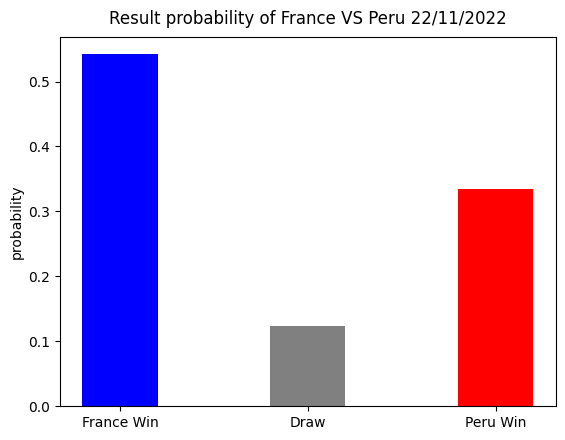

In [35]:
A = Result_df.loc[Result_df['Home Team'] == 'France']
A = A.loc[A['Away Team'] == 'Peru']

data = {'France Win':A['Home Win rate'].values[0], 'Draw':A['Draw rate'].values[0], 'Peru Win':A['Home Lose rate'].values[0]}
number = list(data.keys())
values = list(data.values())
c = ['blue', 'Grey', 'red']

plt.bar(number, values, color = c, width = 0.4)
plt.title("Result probability of France VS Peru 22/11/2022", y=1.012)
plt.ylabel("probability", labelpad=3);

plt.show()

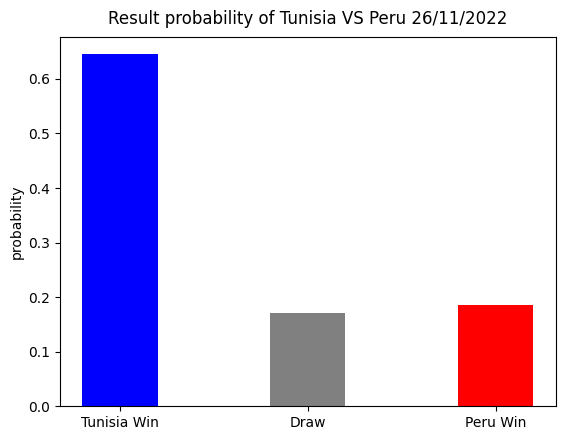

In [36]:
A = Result_df.loc[Result_df['Home Team'] == 'Tunisia']
A = A.loc[A['Away Team'] == 'Peru']

data = {'Tunisia Win':A['Home Win rate'].values[0], 'Draw':A['Draw rate'].values[0], 'Peru Win':A['Home Lose rate'].values[0]}
number = list(data.keys())
values = list(data.values())
c = ['blue', 'Grey', 'red']

plt.bar(number, values, color = c, width = 0.4)
plt.title("Result probability of Tunisia VS Peru 26/11/2022", y=1.012)
plt.ylabel("probability", labelpad=3);

plt.show()

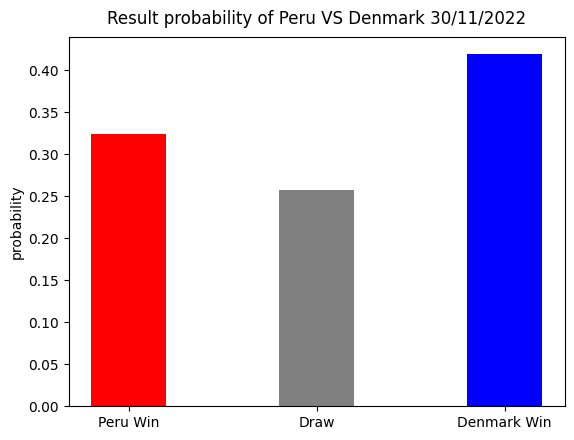

In [37]:
A = Result_df.loc[Result_df['Home Team'] == 'Peru']
A = A.loc[A['Away Team'] == 'Denmark']

data = {'Peru Win':A['Home Win rate'].values[0], 'Draw':A['Draw rate'].values[0], 'Denmark Win':A['Home Lose rate'].values[0]}
number = list(data.keys())
values = list(data.values())
c = ['red', 'Grey', 'blue']

plt.bar(number, values, color = c, width = 0.4)
plt.title("Result probability of Peru VS Denmark 30/11/2022", y=1.012)
plt.ylabel("probability", labelpad=3);

plt.show()